In [22]:
import platform

if platform.system() != "Windows":
    %pip install -q "matplotlib>=3.4"
else:
    %pip install -q "matplotlib>=3.4,<3.7"

# Download model
from pathlib import Path
from ultralytics import YOLO


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [23]:
# Inference function
from ultralytics import YOLO
from ultralytics.solutions import ObjectCounter
import cv2
import time
import collections
import numpy as np
from IPython import display
import torch
import openvino as ov
import ipywidgets as widgets
import matplotlib.pyplot as plt


In [24]:

models_dir = Path("./models")
models_dir.mkdir(exist_ok=True)

DET_MODEL_NAME = "yolov8n"

det_model = YOLO(models_dir / f"{DET_MODEL_NAME}.pt")
label_map = det_model.model.names

# Need to make en empty call to initialize the model
res = det_model()
det_model_path = models_dir / f"{DET_MODEL_NAME}_openvino_model/{DET_MODEL_NAME}.xml"
if not det_model_path.exists():
    det_model.export(format="openvino", dynamic=True, half=True)


WARNING ⚠️ 'source' is missing. Using 'source=/home/nabeel/openvino_env/lib/python3.8/site-packages/ultralytics/assets'.

image 1/2 /home/nabeel/openvino_env/lib/python3.8/site-packages/ultralytics/assets/bus.jpg: 640x480 4 persons, 1 bus, 1 stop sign, 656.1ms
image 2/2 /home/nabeel/openvino_env/lib/python3.8/site-packages/ultralytics/assets/zidane.jpg: 384x640 2 persons, 1 tie, 473.0ms
Speed: 14.6ms preprocess, 564.5ms inference, 7.6ms postprocess per image at shape (1, 3, 384, 640)


In [25]:
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor="green", facecolor=(0, 0, 0, 0), lw=2))

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(
        pos_points[:, 0],
        pos_points[:, 1],
        color="green",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )
    ax.scatter(
        neg_points[:, 0],
        neg_points[:, 1],
        color="red",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )
    

In [29]:

def run_inference(source, deviceType, objectToCount):
    core = ov.Core()
   
    det_ov_model = core.read_model(det_model_path)
    ov_config = {}

    compiled_model = core.compile_model(det_ov_model, deviceType, ov_config)

    def infer(*args):
        result = compiled_model(args)
        return torch.from_numpy(result[0])

    # Use openVINO as inference engine
    det_model.predictor.inference = infer
    det_model.predictor.model.pt = False

    try:
        cap = cv2.VideoCapture(source)
        assert cap.isOpened(), "Error reading video file"
        # line_points = [(0, 300), (1080, 300)]  
        # line_points = [(0, 1080, 1080, 0, 0), (300, 300,0,0, 300)]  # line or region points
        line_points = [(0, 300), (500, 300),(500, 0),(0,0),(0,300)]  # line or region points

        classes_to_count = [0]  # person is class 0 in the COCO dataset, 46 is banana and 47 is apples.
        if(objectToCount == "person"):
            classes_to_count == [0]
        if(objectToCount == "banana"):
            classes_to_count = [46]
        if(objectToCount == "apple"):
           classes_to_count = [47]

           
        # Init Object Counter
        counter = ObjectCounter(
            view_img=False, reg_pts=line_points, classes_names=det_model.names, draw_tracks=True, line_thickness=1, view_in_counts=False, view_out_counts=False
        )
        # Processing time
        processing_times = collections.deque(maxlen=200)

        while cap.isOpened():
            success, frame = cap.read()
            if not success:
                print("Video frame is empty or video processing has been successfully completed.")
                break

            start_time = time.time()
            tracks = det_model.track(frame, persist=True, show=False, classes=classes_to_count, verbose=False)
            frame = counter.start_counting(frame, tracks)
            stop_time = time.time()

            processing_times.append(stop_time - start_time)

            # Mean processing time [ms].
            _, f_width = frame.shape[:2]
            processing_time = np.mean(processing_times) * 1000
            fps = 1000 / processing_time
            cv2.putText(
                img=frame,
                text=f"Inference time: {processing_time:.1f}ms ({fps:.1f} FPS)",
                org=(20, 40),
                fontFace=cv2.FONT_HERSHEY_COMPLEX,
                fontScale=f_width / 1000,
                color=(0, 0, 255),
                thickness=2,
                lineType=cv2.LINE_AA,
            )

            # Get the counts. Counts are getting as 'OUT'
            # Modify this logic accordingly
            counts = counter.out_counts

            # Define the text to display
            text = f"Count: {counts}"
            fontFace = cv2.FONT_HERSHEY_COMPLEX
            fontScale = 0.75  # Adjust scale as needed
            thickness = 2

            # Calculate the size of the text box
            (text_width, text_height), _ = cv2.getTextSize(text, fontFace, fontScale, thickness)

            # Define the upper right corner for the text
            top_right_corner = (frame.shape[1] - text_width - 20, 40)
            # Draw the count of "OUT" on the frame
            cv2.putText(
                img=frame,
                text=text,
                org=(top_right_corner[0], top_right_corner[1]),
                fontFace=fontFace,
                fontScale=fontScale,
                color=(0, 0, 255),
                thickness=thickness,
                lineType=cv2.LINE_AA,
            )

            # Show the frame
            _, encoded_img = cv2.imencode(ext=".jpg", img=frame, params=[cv2.IMWRITE_JPEG_QUALITY, 100])
            # Create an IPython image.
            i = display.Image(data=encoded_img)
            # Display the image in this notebook.          
            display.clear_output(wait=True)
            display.display(i)
    except KeyboardInterrupt:
        print("Interrupted")

    cap.release()
    cv2.destroyAllWindows()

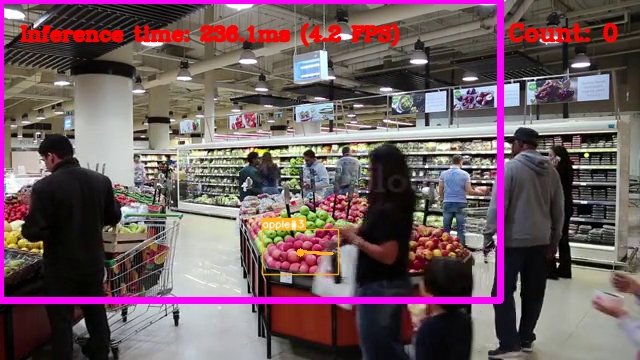

Video frame is empty or video processing has been successfully completed.


In [31]:
VIDEO_SOURCE = "https://dm0qx8t0i9gc9.cloudfront.net/watermarks/video/49_20HQOeijh9fog1/uae-dubai-february-1-2016-people-near-shop-counter-with-fresh-fruits-inside-dubai-mall-in-united-arab-emirates-dubai-mall-is-the-world-largest-shopping-mall_nixdioorg__54efbe10ef1db686a89eb84a13815e70__P360.mp4"

core = ov.Core()
deviceType = "CPU"

run_inference(
    source=VIDEO_SOURCE,
    deviceType=deviceType,
    objectToCount="apple"
)